# Using submodel loss of active materials in PyBaMM
In this notebook we show how to use the loss of active materials (LAM) submodel in pybamm. The LAM model follows the equation (25) from Ref [1](https://iopscience.iop.org/article/10.1149/2.0281914jes), and the stresses are calculated by equations (7-9) in Ref [2](https://doi.org/10.1149/2.0122001JES). To see all of the models and submodels available in PyBaMM, please take a look at the documentation [here](https://pybamm.readthedocs.io/en/latest/source/models/index.html). 

In [1]:
%pip install pybamm -q
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')
model = pybamm.lithium_ion.DFN(
    options=
    {
        "particle": "Fickian diffusion", 
        "sei":"solvent-diffusion limited", 
        "sei film resistance":"distributed", 
        "sei porosity change":False, 
        "particle cracking":"no cracking",
        "loss of active materials":True,
    }
)
chemistry = pybamm.parameter_sets.Ai2020
param = pybamm.ParameterValues(chemistry=chemistry)
param.update({"Negative electrode LAM constant beta": 0})
param.update({"Positive electrode LAM constant beta": 1e-4})
total_cycles = 2
experiment = pybamm.Experiment(
    [
        "Discharge at 1C until 3 V",
        "Rest for 600 seconds",
        "Charge at 1C until 4.2 V",
        "Hold at 4.199 V for 600 seconds",
    ] * total_cycles
)
sim1 = pybamm.Simulation(
    model, 
    experiment = experiment,
    parameter_values = param,
    solver = pybamm.CasadiSolver(dt_max=100),
)
solution = sim1.solve()


For validation, the result is compared with the original model without loss of active materials

In [2]:
t_all = solution["Time [h]"].entries
v_all = solution["Terminal voltage [V]"].entries
I_if_p = solution["Sum of x-averaged negative electrode interfacial current densities"].entries
I_if_n = solution["Sum of x-averaged positive electrode interfacial current densities"].entries

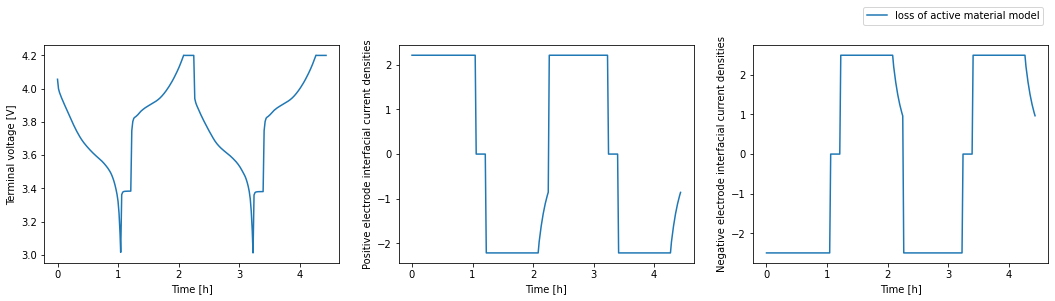

In [3]:
# ploting the results
f, (ax1, ax2, ax3) = plt.subplots(1, 3 ,figsize=(18,4))

ax1.plot(t_all, v_all, label="loss of active material model")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Terminal voltage [V]")
#ax1.legend()


ax2.plot(t_all, I_if_p, label="loss of active material model")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Positive electrode interfacial current densities")
#ax2.legend()
#ax2.set_xlim(6000,7000)

ax3.plot(t_all, I_if_n, label="loss of active material model")
ax3.set_xlabel("Time [h]")
ax3.set_ylabel("Negative electrode interfacial current densities")
ax3.legend(bbox_to_anchor=(1, 1.2))
#ax3.set_xlim(10000,15000)
# f.tight_layout(pad=1.0)
plt.show()


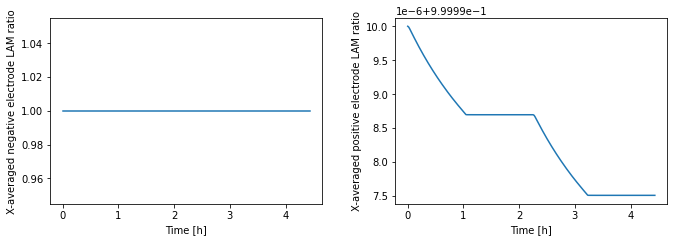

In [4]:
LAM_n_all = solution["X-averaged negative electrode LAM ratio"].entries
LAM_p_all = solution["X-averaged positive electrode LAM ratio"].entries
f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,4))
ax1.plot(t_all, LAM_n_all, label="loss of active material model")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("X-averaged negative electrode LAM ratio")

ax2.plot(t_all, LAM_p_all, label="loss of active material model")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("X-averaged positive electrode LAM ratio")
f.tight_layout(pad=3.0)
plt.show()

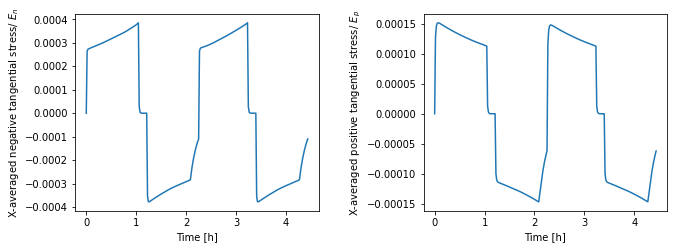

In [5]:
S_t_n_all = solution["X-averaged negative particle surface tangential stress"].entries
S_t_p_all = solution["X-averaged positive particle surface tangential stress"].entries
f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,4))
ax1.plot(t_all, S_t_n_all, label="loss of active material model")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("X-averaged negative tangential stress/ $E_n$")

ax2.plot(t_all, S_t_p_all, label="loss of active material model")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("X-averaged positive tangential stress/ $E_p$")
f.tight_layout(pad=3.0)
plt.show()

In [6]:
k1 = 1e-4
k2 = 1e-3
k3 = 1e-2
param.update({"Positive electrode LAM constant beta": k2})
sim2 = pybamm.Simulation(
    model, 
    experiment=experiment,
    parameter_values=param,
    solver=pybamm.CasadiSolver(dt_max=100),
)
solution2 = sim2.solve()
param.update({"Positive electrode LAM constant beta": k3})
sim3 = pybamm.Simulation(
    model, 
    experiment=experiment,
    parameter_values=param,
    solver=pybamm.CasadiSolver(dt_max=100),
)
solution3 = sim3.solve()

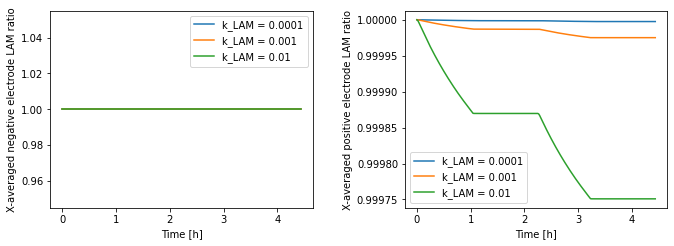

In [7]:
t_all2 = solution2["Time [h]"].entries
t_all3 = solution3["Time [h]"].entries
LAM_n_all2 = solution2["X-averaged negative electrode LAM ratio"].entries
LAM_p_all2 = solution2["X-averaged positive electrode LAM ratio"].entries
LAM_n_all3 = solution3["X-averaged negative electrode LAM ratio"].entries
LAM_p_all3 = solution3["X-averaged positive electrode LAM ratio"].entries

f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,4))
ax1.plot(t_all, LAM_n_all, label="k_LAM = "+ str(k1))
ax1.plot(t_all2, LAM_n_all2, label="k_LAM = "+ str(k2))
ax1.plot(t_all3, LAM_n_all3, label="k_LAM = "+ str(k3))
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("X-averaged negative electrode LAM ratio")
ax1.legend()
ax2.plot(t_all, LAM_p_all, label="k_LAM = "+ str(k1))
ax2.plot(t_all2, LAM_p_all2, label="k_LAM = "+ str(k2))
ax2.plot(t_all3, LAM_p_all3, label="k_LAM = "+ str(k3))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("X-averaged positive electrode LAM ratio")
f.tight_layout(pad=3.0)
ax2.legend()
plt.show()

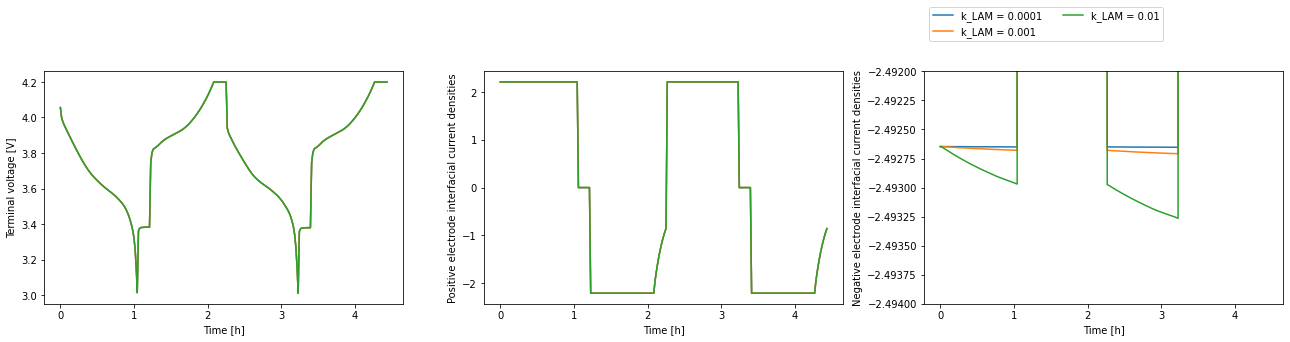

In [8]:
v_all = solution["Terminal voltage [V]"].entries
v_all2 = solution2["Terminal voltage [V]"].entries
v_all3 = solution3["Terminal voltage [V]"].entries
I_if_p2 = solution2["Sum of x-averaged negative electrode interfacial current densities"].entries
I_if_n2 = solution2["Sum of x-averaged positive electrode interfacial current densities"].entries
I_if_p3 = solution3["Sum of x-averaged negative electrode interfacial current densities"].entries
I_if_n3 = solution3["Sum of x-averaged positive electrode interfacial current densities"].entries

f, (ax1, ax2, ax3) = plt.subplots(1, 3 ,figsize=(18,5))
ax1.plot(t_all, v_all, label="k_LAM = "+ str(k1))
ax1.plot(t_all2, v_all2, label="k_LAM = "+ str(k2))
ax1.plot(t_all3, v_all3, label="k_LAM = "+ str(k3))
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Terminal voltage [V]")
#ax1.legend()

ax2.plot(t_all, I_if_p, label="k_LAM = "+ str(k1))
ax2.plot(t_all2, I_if_p2, label="k_LAM = "+ str(k2))
ax2.plot(t_all3, I_if_p3, label="k_LAM = "+ str(k3))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Positive electrode interfacial current densities")
#ax2.legend()
#ax2.set_xlim(6000,7000)

ax3.plot(t_all, I_if_n, label="k_LAM = "+ str(k1))
ax3.plot(t_all2, I_if_n2, label="k_LAM = "+ str(k2))
ax3.plot(t_all3, I_if_n3, label="k_LAM = "+ str(k3))
ax3.set_xlabel("Time [h]")
ax3.set_ylabel("Negative electrode interfacial current densities")
ax3.legend(bbox_to_anchor=(0.68, 1.3), ncol=2)
#ax3.set_xlim(2,2.8)
ax3.set_ylim(-2.494,-2.492)
plt.tight_layout(pad=1.0)
plt.show()


## Reference
[1] Reniers, J. M., Mulder, G., & Howey, D. A. (2019). Review and performance comparison of mechanical-chemical degradation models for lithium-ion batteries. Journal of The Electrochemical Society, 166(14), A3189.

[2] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2019). Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512.